In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers, models

In [ ]:
df= pd.read_csv('/content/GOOG.csv')
df.drop(['symbol'], axis=1, inplace=True)
date = []
for i in range(len(df)):
    date.append(df['date'][i][:10])
df['date'] = date
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'adjClose', 'adjHigh',
       'adjLow', 'adjOpen', 'adjVolume', 'divCash', 'splitFactor'],
      dtype='object')

<Axes: >

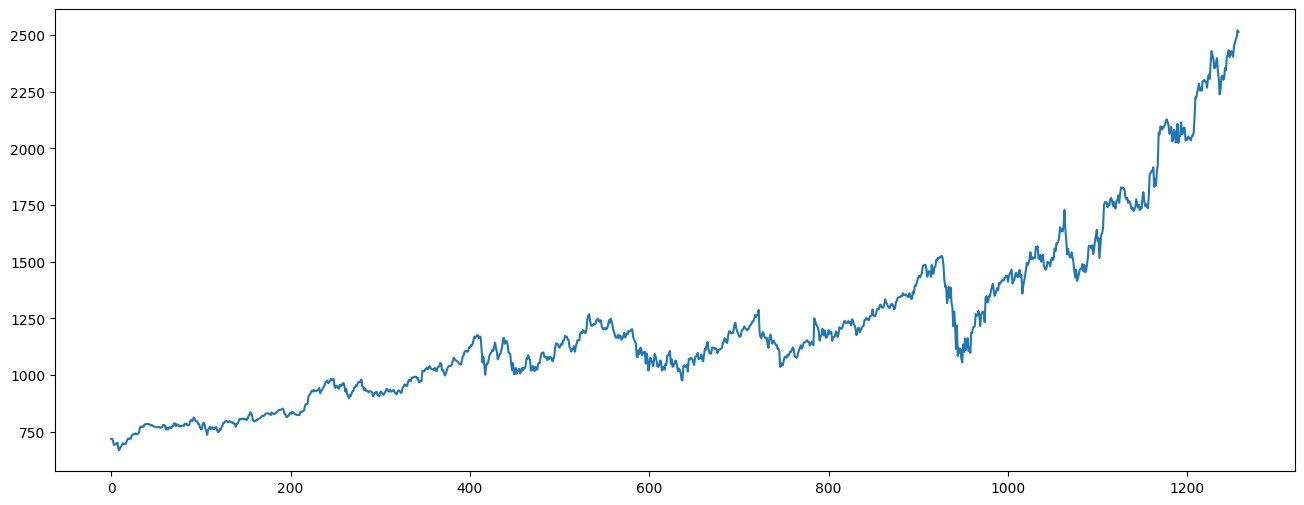

In [ ]:
df['close'].plot(figsize=(16,6))

In [ ]:
df.drop(columns = ['adjClose', 'adjHigh',
       'adjLow', 'adjOpen', 'adjVolume', 'divCash', 'splitFactor'],inplace=True)

In [ ]:
df.set_index('date', inplace=True)

In [ ]:
df

,close,high,low,open,volume
date,,,,,
2016-06-14,718.27,722.470,713.1200,716.48,1306065
2016-06-15,718.92,722.980,717.3100,719.00,1214517
2016-06-16,710.36,716.650,703.2600,714.91,1982471
2016-06-17,691.72,708.820,688.4515,708.65,3402357
2016-06-20,693.71,702.480,693.4100,698.77,2082538
...,...,...,...,...,...
2021-06-07,2466.09,2468.000,2441.0725,2451.32,1192453
2021-06-08,2482.85,2494.495,2468.2400,2479.90,1253253
2021-06-09,2491.40,2505.000,2487.3300,2499.50,1006337


In [ ]:
df.describe()

,close,high,low,open,volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,1216.317067,1227.430934,1204.176430,1215.260779,1.601590e+06
std,383.333358,387.570872,378.777094,382.446995,6.960172e+05
min,668.260000,672.300000,663.284000,671.000000,3.467530e+05
25%,960.802500,968.757500,952.182500,959.005000,1.173522e+06
50%,1132.460000,1143.935000,1117.915000,1131.150000,1.412588e+06
75%,1360.595000,1374.345000,1348.557500,1361.075000,1.812156e+06
max,2521.600000,2526.990000,2498.290000,2524.920000,6.207027e+06


Text(0.5, 1.0, 'Volume History')

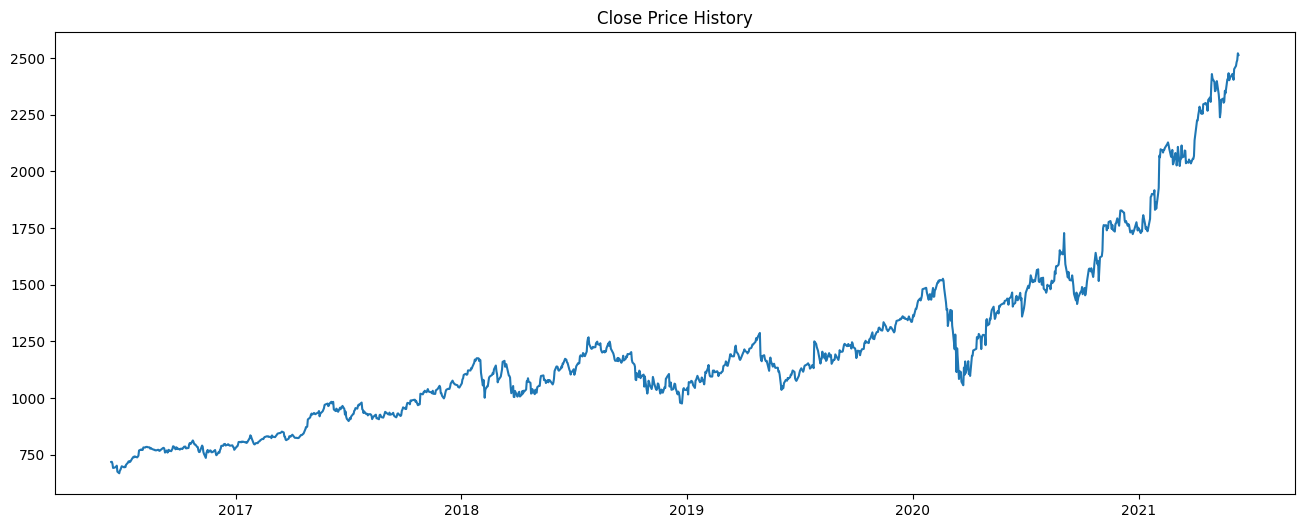

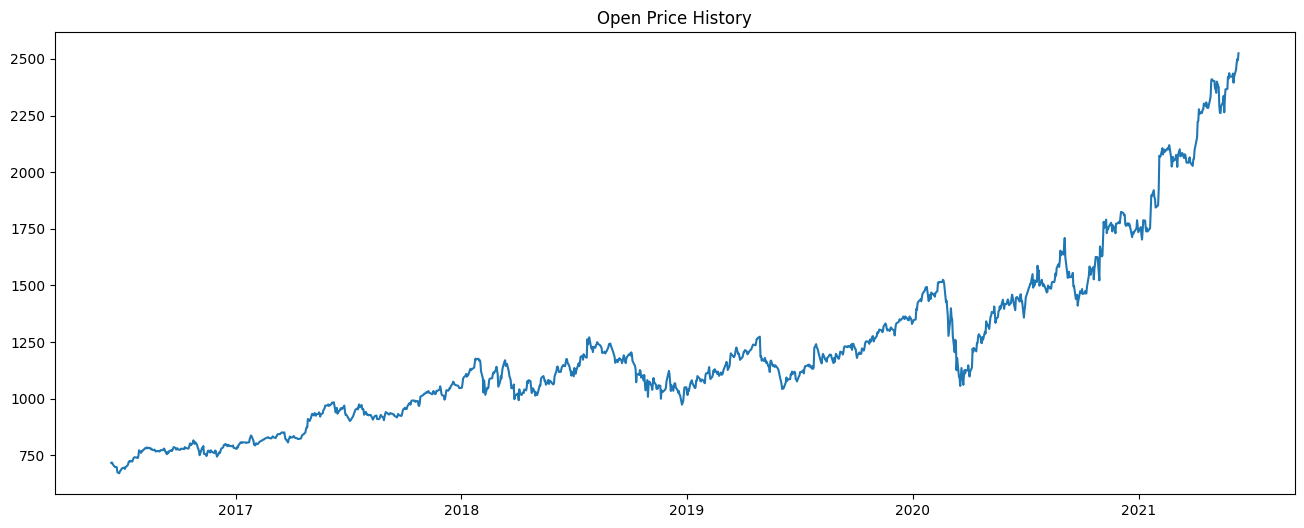

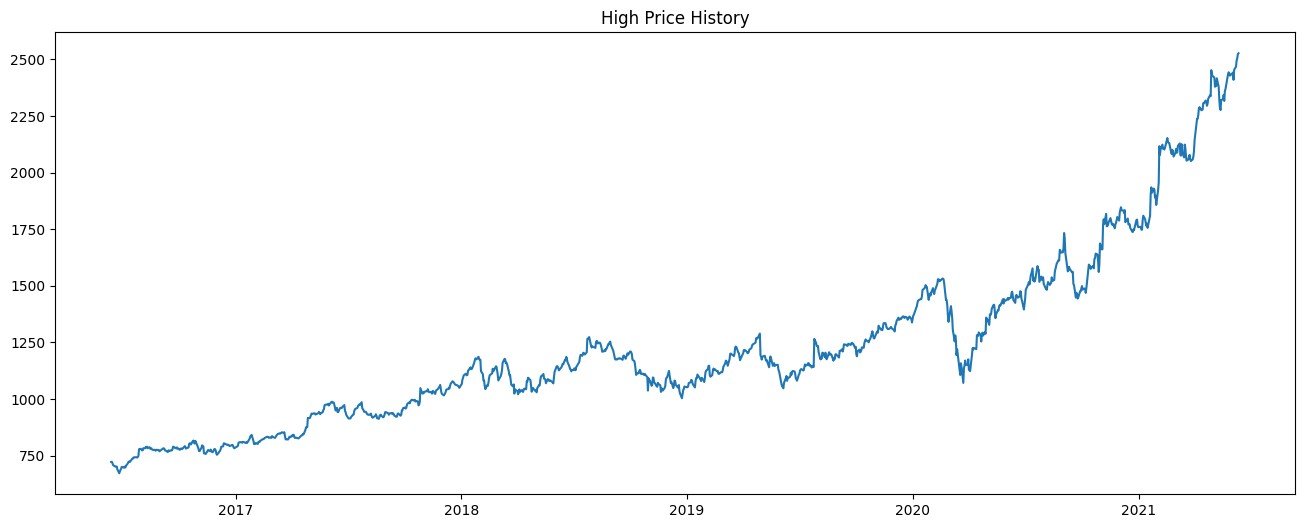

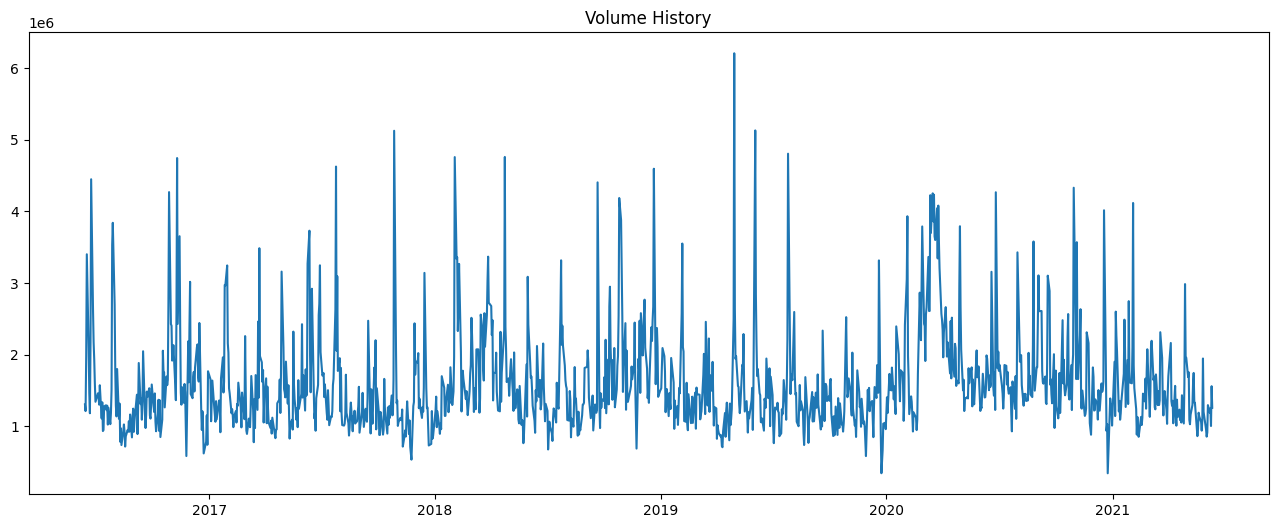

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(df['close'])
plt.title('Close Price History')
plt.figure(figsize=(16,6))
plt.plot(df['open'])
plt.title('Open Price History')
plt.figure(figsize=(16,6))
plt.plot(df['high'])
plt.title('High Price History')
plt.figure(figsize=(16,6))
plt.plot(df['volume'])
plt.title('Volume History')

In [ ]:
target = df["close"]
target = pd.DataFrame(target)

data = target.values

data.shape

(1258, 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))

In [ ]:
train_size = int(len(data)*.75)
test_size = len(data) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

train_data = scaled_data[ :train_size , 0:1 ]
test_data = scaled_data[ train_size-60: , 0:1 ]

Train Size : 943 Test Size : 315


In [ ]:
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape , y_train.shape

((883, 60, 1), (883,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dropout, Dense
from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import schedules

model = Sequential([
    Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)),
    LSTM(128, return_sequences=True),
    Dropout(0.1),
    LSTM(64, return_sequences=True),
    Dropout(0.1),
    LSTM(32, return_sequences=False),
    Dropout(0.1),
    Dense(16, activation='relu'),
    Dense(1,activation='linear')
])

model.compile(optimizer= 'adam', loss= 'mse' , metrics= ["mean_absolute_error"])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 256)           1024      
                                                                 
 lstm (LSTM)                 (None, 58, 128)           197120    
                                                                 
 dropout (Dropout)           (None, 58, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 58, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 58, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor= 'loss', patience= 10 , restore_best_weights= True)]
history = model.fit(x_train, y_train, epochs= 100, batch_size= 32 , callbacks= callbacks)

Epoch 1/100
28/28 [==============================] - 14s 204ms/step - loss: 0.0085 - mean_absolute_error: 0.0688
Epoch 2/100
28/28 [==============================] - 8s 271ms/step - loss: 0.0015 - mean_absolute_error: 0.0288
Epoch 3/100
28/28 [==============================] - 6s 200ms/step - loss: 9.9170e-04 - mean_absolute_error: 0.0232
Epoch 4/100
28/28 [==============================] - 7s 259ms/step - loss: 9.8367e-04 - mean_absolute_error: 0.0229
Epoch 5/100
28/28 [==============================] - 6s 204ms/step - loss: 8.8932e-04 - mean_absolute_error: 0.0223
Epoch 6/100
28/28 [==============================] - 6s 212ms/step - loss: 9.8102e-04 - mean_absolute_error: 0.0231
Epoch 7/100
28/28 [==============================] - 7s 250ms/step - loss: 7.1050e-04 - mean_absolute_error: 0.0195
Epoch 8/100
28/28 [==============================] - 6s 196ms/step - loss: 8.3357e-04 - mean_absolute_error: 0.0213
Epoch 9/100
28/28 [==============================] - 7s 268ms/step - loss: 0.00

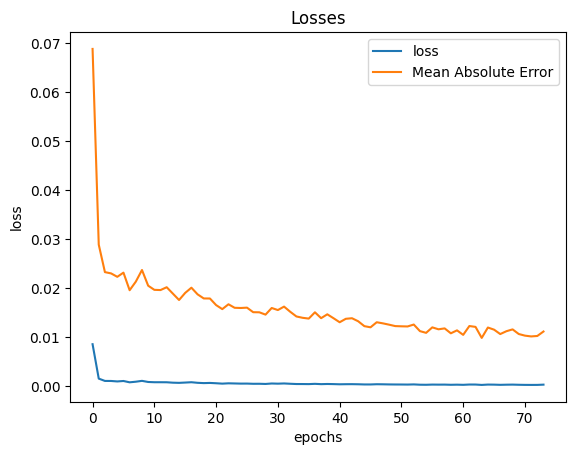

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['loss','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
x_test.shape, y_test.shape

((315, 60, 1), (315,))

In [ ]:
predictions = model.predict(x_test)

10/10 [==============================] - 2s 62ms/step


In [ ]:
predictions = scaler.inverse_transform(predictions)

In [ ]:
y_test = scaler.inverse_transform([y_test])

In [ ]:
RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

117.58

In [ ]:
len(predictions)

315

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test.squeeze(), predictions.squeeze())

0.8202843092694849

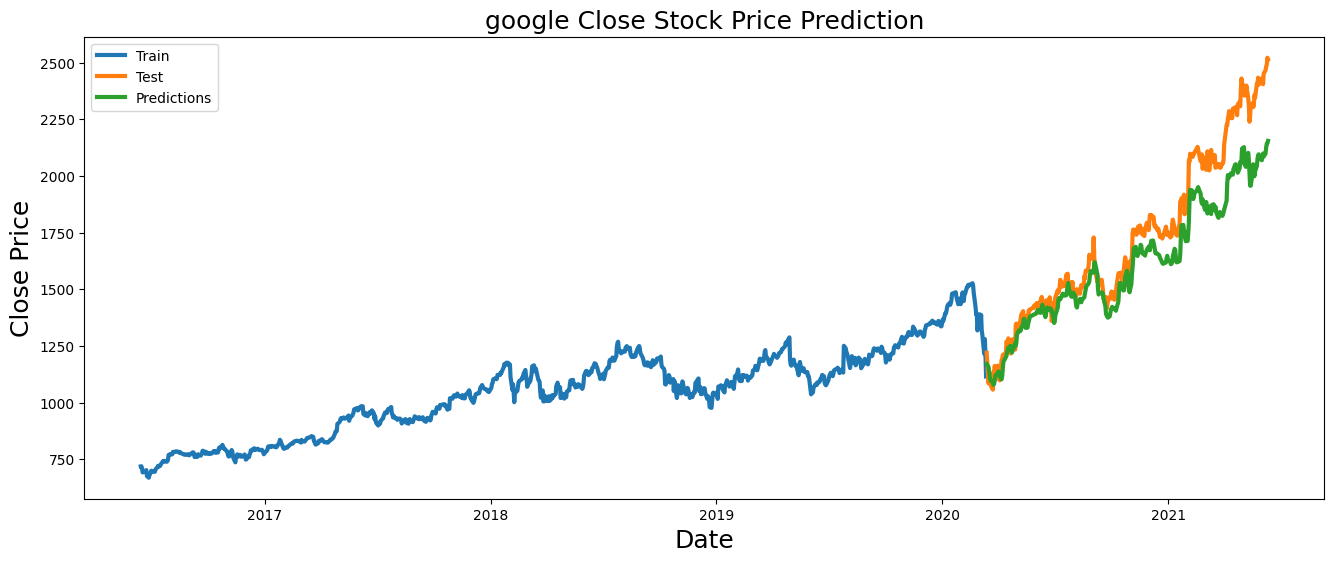

In [ ]:
train = target.iloc[:train_size , 0:1]
test = target.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('google Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train['close'], linewidth= 3)
plt.plot(test['close'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])